In [63]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import MultiLineString
from shapely.geometry import Polygon
from shapely.ops import nearest_points
from shapely.ops import unary_union

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

pd.set_option('display.max_columns', None)

%matplotlib inline

# For this example, I have three datasets to work with:
## 1. "lower48_borders"--this contains US state/national borders for the contiguous 48 states.
## 2. "existing_MA"--these points are existing wind turbines in the state of Massachusetts (hoping to expand this to cover all 50 states in my capstone)
## 3. "MA_lines"--high-voltage transmission lines in Massachusetts. 

In [64]:
lower48_borders = gpd.read_file('./lower48_borders.geojson',driver='GeoJSON')

In [65]:
existing_MA = gpd.read_file('./existing_MA.geojson',driver='GeoJSON')

In [66]:
MA_lines = gpd.read_file('./MA_lines.geojson',driver='GeoJSON')
MA_lines.drop('index_right',axis='columns',inplace=True)

In [67]:
MA_lines.columns

Index(['OBJECTID', 'ID', 'TYPE', 'STATUS', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'OWNER', 'VOLTAGE',
       'VOLT_CLASS', 'INFERRED', 'SUB_1', 'SUB_2', 'SHAPE__Len', 'state',
       'geometry'],
      dtype='object')

In [68]:
MA_lines.describe()

,OBJECTID,VOLTAGE,SHAPE__Len
count,86.000000,86.000000,86.000000
mean,28950.674419,328.837209,30891.674913
std,17952.563583,43.451626,38165.179850
min,221.000000,230.000000,97.360582
25%,10804.500000,345.000000,10467.111897
50%,29889.000000,345.000000,23575.871956
75%,44162.250000,345.000000,39259.373184
max,57932.000000,450.000000,295414.622777


### What I'd like to do is find the nearest transmission line for each turbine--not just the shortest distance to a line--I was able to figure that out pretty quickly--but the line that is the shortest distance away.

### Ideally, once the shortest distance is calculated, whatever function performed this calculation will return the OBJECTID of the line, so I can use that to access whichever attributes of a given line I need later (like VOLTAGE, VOLT_CLASS, etc.).

I'm going to be doing a LOT of similar calculations to create features using these datasets, and at least one more (NREL wind data). So it irks me that I haven't been able to find a working solution to what feels like a relatively simple problem...

Some solutions I've already attempted include:

* I tried adapting the ckdnearest solution from Markus Rosenfelder at the bottom of [this page](https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe).
* The recommended solution on [this stackoverflow page](https://stackoverflow.com/questions/30740046/calculate-distance-to-nearest-feature-with-geopandas/32662259) shows how to find the minimum distance from a point to a line, but not how to get any attributes about the line.
* [This Nearest Neighbor Analysis article](https://towardsdatascience.com/nearest-neighbour-analysis-with-geospatial-data-7bcd95f34c0e) seems like it is doing what I want, but I got a little lost in that I don't think the code that is shown is a working solution, and I had trouble putting it all together in my head.
* I've also been browsing [the Shapely user manual](https://shapely.readthedocs.io/en/stable/manual.html), but the examples aren't always helpful.

In [69]:
existing_MA

,index,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,turbine_class,geometry
0,198,3046262.0,25-025115,2013-WTE-5497-OE,26723.0,MA,Barnstable County,25001,6th Space Warning Squadron,2013.0,2.0,3.36,GE Wind,GE1.68-82.5,1680.0,80.0,82.5,5345.62,121.3,3.0,3.0,None,Digital Globe,-70.541801,41.752491,0,POINT (-70.54180 41.75249)
1,199,3046335.0,25-025116,2013-WTE-5773-OE,26722.0,MA,Barnstable County,25001,6th Space Warning Squadron,2013.0,2.0,3.36,GE Wind,GE1.68-82.5,1680.0,80.0,82.5,5345.62,121.3,3.0,3.0,None,Digital Globe,-70.545303,41.754192,0,POINT (-70.54530 41.75419)
2,200,3039277.0,25-022039,2011-WTE-7516-OE,26676.0,MA,Barnstable County,25001,AFCEE MMR Turbines,2011.0,2.0,3.00,GE Wind,GE1.5-77,1500.0,80.0,77.0,4656.63,118.6,3.0,3.0,None,Digital Globe,-70.545303,41.757591,0,POINT (-70.54530 41.75759)
3,201,3039278.0,25-022038,2011-WTE-7517-OE,26677.0,MA,Barnstable County,25001,AFCEE MMR Turbines,2011.0,2.0,3.00,GE Wind,GE1.5-77,1500.0,80.0,77.0,4656.63,118.6,3.0,3.0,None,Digital Globe,-70.547798,41.759590,0,POINT (-70.54780 41.75959)
4,405,3034436.0,25-020032,2010-WTE-15019-OE,26672.0,MA,Barnstable County,25001,Air Force (Barnstable),2009.0,1.0,1.50,Fuhrlander,FL1500,1500.0,80.0,77.0,4656.63,118.6,3.0,3.0,2012-01-01,NAIP,-70.591103,41.657692,0,POINT (-70.59110 41.65769)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,52980,3042077.0,25-022236,2012-WTE-2583-OE,26669.0,MA,Bristol County,25005,University of Massachussetts Dartmouth,2012.0,1.0,0.60,Turbowinds,T-600-48,600.0,50.0,48.0,1809.56,74.1,3.0,3.0,2012-01-01,NAIP,-71.010597,41.626690,2,POINT (-71.01060 41.62669)
86,55513,3026616.0,25-020024,2008-ANE-443-OE,26683.0,MA,Berkshire County,25003,Williams Stone,2009.0,1.0,0.60,RRB,PS-600,600.0,65.0,47.0,1734.94,88.4,3.0,3.0,2012-01-01,NAIP,-73.069901,42.234192,2,POINT (-73.06990 42.23419)
87,56271,3008244.0,missing,missing,26720.0,MA,Barnstable County,25001,Woods Hole Research Center,2009.0,1.0,0.10,Northern Power Systems,NW100,100.0,37.0,21.0,346.36,47.5,2.0,3.0,2017-04-30,Digital Globe,-70.643204,41.548992,2,POINT (-70.64320 41.54899)
88,56769,3092344.0,25-062961,2018-WTE-7276-OE,-9999.0,MA,Berkshire County,25003,unknown Berkshire County,2019.0,2.0,-9999.00,missing,missing,-9999.0,-9999.0,-9999.0,-9999.00,-9999.0,1.0,1.0,2018-05-26,Digital Globe,-73.272507,42.596329,1,POINT (-73.27251 42.59633)


In [70]:
MA_nearest_df = gpd.GeoDataFrame(existing_MA['index'].copy(deep=True))
MA_nearest_df['geometry'] = existing_MA['geometry'].apply(lambda x: nearest_points(x,
                                                           MultiLineString(MA_lines['geometry'].values)))

In [71]:
MA_nearest_df

,index,geometry
0,198,"(POINT (-70.54180100000001 41.752491), POINT (..."
1,199,"(POINT (-70.545303 41.754192), POINT (-70.5471..."
2,200,"(POINT (-70.545303 41.757591), POINT (-70.5488..."
3,201,"(POINT (-70.547798 41.75959), POINT (-70.55076..."
4,405,"(POINT (-70.591103 41.657692), POINT (-70.5367..."
...,...,...
85,52980,"(POINT (-71.010597 41.62669), POINT (-71.18313..."
86,55513,"(POINT (-73.069901 42.234192), POINT (-73.0971..."
87,56271,"(POINT (-70.643204 41.548992), POINT (-70.5367..."
88,56769,"(POINT (-73.272507 42.596329), POINT (-73.2926..."


In [72]:
MA_nearest_df['t_geometry'] = gpd.GeoSeries(MA_nearest_df['geometry'].apply(lambda x: x[0]))
MA_nearest_df['geometry'] = gpd.GeoSeries(MA_nearest_df['geometry'].apply(lambda x: x[1]))

In [73]:
MA_nearest_df

,index,geometry,t_geometry
0,198,POINT (-70.54498 41.74997),POINT (-70.54180 41.75249)
1,199,POINT (-70.54716 41.75270),POINT (-70.54530 41.75419)
2,200,POINT (-70.54882 41.75478),POINT (-70.54530 41.75759)
3,201,POINT (-70.55077 41.75722),POINT (-70.54780 41.75959)
4,405,POINT (-70.53674 41.73961),POINT (-70.59110 41.65769)
...,...,...,...
85,52980,POINT (-71.18313 41.72257),POINT (-71.01060 41.62669)
86,55513,POINT (-73.09713 42.46710),POINT (-73.06990 42.23419)
87,56271,POINT (-70.53674 41.73961),POINT (-70.64320 41.54899)
88,56769,POINT (-73.29266 42.53327),POINT (-73.27251 42.59633)


# Single-row attempt

In [74]:
# Choose ONE point. I seem to need to do a slice here, as a single index
# causes some "no numeric data" error
MA_one_point = existing_MA.iloc[0:1]

# Choose ONE line.
MA_one_line = MA_lines.iloc[50:51]

# Find the closest point on the line to the ONE point.
# The results seem to be a lot more useable when contained in a GeoDataFrame.
MA_nearest_one_df = gpd.GeoDataFrame(MA_one_point['index'].copy(deep=True))
MA_nearest_one_df['geometry'] = MA_one_point['geometry'].apply(lambda x: nearest_points(x,
                                                           MultiLineString(MA_one_line['geometry'].values)))
print(MA_nearest_one_df['geometry'])

# Break the result into two columns: t_geometry is the location of the original point;
#                                      geometry now holds the closest point on the line
MA_nearest_one_df['t_geometry'] = gpd.GeoSeries(MA_nearest_one_df['geometry'].apply(lambda x: x[0]))
MA_nearest_one_df['geometry'] = gpd.GeoSeries(MA_nearest_one_df['geometry'].apply(lambda x: x[1]))

# Figure out how to positively identify the closest point as being on the ONE line...

0    (POINT (-70.54180100000001 41.752491), POINT (...
Name: geometry, dtype: object


In [75]:
MA_one_point

,index,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,turbine_class,geometry
0,198,3046262.0,25-025115,2013-WTE-5497-OE,26723.0,MA,Barnstable County,25001,6th Space Warning Squadron,2013.0,2.0,3.36,GE Wind,GE1.68-82.5,1680.0,80.0,82.5,5345.62,121.3,3.0,3.0,None,Digital Globe,-70.541801,41.752491,0,POINT (-70.54180 41.75249)


In [76]:
MA_one_line

,OBJECTID,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,state,geometry
50,34695,116652,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.vtep.org/do...",2015-09-21T00:00:00,IMAGERY,2015-10-01T00:00:00,NOT AVAILABLE,345.0,345,Y,UNKNOWN133485,LUDLOW,11527.067214,MA,"LINESTRING (-72.50834 42.19796, -72.50797 42.1..."


In [77]:
# Uncomment pd.set_option... to see the full contents of the columns.
# Fair warning, linestrings are a LOT of points. :)
#pd.set_option('display.max_colwidth', -1)

print(MA_one_line['geometry'])

50    LINESTRING (-72.50834 42.19796, -72.50797 42.1...
Name: geometry, dtype: geometry


In [78]:
MA_nearest_one_df

,index,geometry,t_geometry
0,198,POINT (-72.44651 42.19552),POINT (-70.54180 41.75249)


<Figure size 432x288 with 0 Axes>

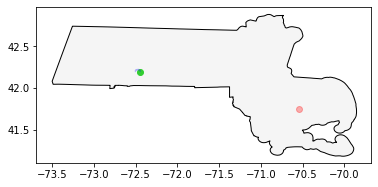

In [79]:
# Plot our state borders, the point (red), the line (blue), the nearest point on the line (green)
fig = plt.figure()
ax = lower48_borders.loc[lower48_borders['STUSPS'] == 'MA'].plot(color='whitesmoke',edgecolor='black')
MA_one_point.plot(ax=ax, color='red',alpha=.3)
MA_one_line.plot(ax=ax,color='blue',alpha=.3)
MA_nearest_one_df.plot(ax=ax,color='limegreen')

In [80]:
# Take another peek at some calculated values
for idx,this_row in MA_nearest_one_df.iterrows():
    print("INDEX {}:".format(idx))
    print("Location of the turbine: ",this_row['t_geometry'])
    print("Location of the closest point to this turbine on the transmission line: ",this_row['geometry'])
# .distance() is a method of Shapely objects, not of Geopandas series or dataframes
    print("Distance between these two points: ",this_row['t_geometry'].distance(this_row['geometry']))
# What's the distance from our line(s?) to the point in this_row, which should be ON the line?
    print("Distance between the line, and the point (allegedly) ON the line: ",
          MA_one_line['geometry'].distance(this_row['geometry']).values)

INDEX 0:
Location of the turbine:  POINT (-70.54180100000001 41.752491)
Location of the closest point to this turbine on the transmission line:  POINT (-72.44651477799989 42.195516817)
Distance between these two points:  1.9555578361764507
Distance between the line, and the point (allegedly) ON the line:  [0.]


In [81]:
# Shapely does not consider the endpoints of a linestring to be "contained" in the line. 
# So if the nearest point IS an endpoint, .contains() will return False.
MA_one_line['geometry'].contains(MA_nearest_one_df['geometry'])#.values

0     False
50    False
dtype: bool

In [82]:
# On the other hand, .intersects() supposedly considers ANY intersection--
# "Returns True if the boundary or interior of the object intersect in any way with those of the other."
MA_one_line['geometry'].intersects(MA_nearest_one_df['geometry'])#.values

# HOWEVER--what I am finding is that any distance greater than zero, however tiny (1e-15 tiny) is still
# not considered to be an intersection. That sucks because floating point errors seem to create these
# tiny distances often enough to be a major problem.

0     False
50    False
dtype: bool

In [83]:
# This was returning the indexes of the point (10--chose MA_one_point[10:11])
#  and the line (MA_one_line[22:23]). I presume these indexes will change if the selection changes,
# so I am running reset_index() before indexing [0] to be able to consistently select the first element.
MA_one_line['geometry'].distance(MA_nearest_one_df['geometry']).reset_index(drop=True)[0]

nan

### We can retrieve the OBJECTID of the line, from which we can get any other attributes we need.

In [84]:
MA_one_line.loc[MA_one_line.intersects(MA_nearest_one_df['geometry'][0]),'OBJECTID']

50    34695
Name: OBJECTID, dtype: int64

## End of single-row attempt.

# So now, make this work for all of the points.

Recall:
* lower48_borders - state/national border dataset
* existing_MA - existing turbines in MA
* MA_lines - transmission lines in MA

And in the last section, we also created:
* MA_nearest_df - contains the "index" column from the turbine dataset, the location of each turbine ['t_geometry'], and the closest point of the closest transmission line ['geometry']. Should have the same shape as existing_MA?

Let's see if we can speed things up by creating a unary_union of all of the transmission lines--then, we'll only have that one (albeit large) object to compare to each point.


In [85]:
print(existing_MA.shape)
print(MA_nearest_df.shape)
# Should have the same number of rows. It'll make our lives easier.

(90, 27)
(90, 3)


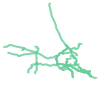

In [86]:
lines_union = MA_lines['geometry'].unary_union
lines_union

In [87]:
MA_nearest_df = gpd.GeoDataFrame(existing_MA['index'].copy(deep=True))
# This calculation should be simpler if we're only comparing points to a single object...?
MA_nearest_df['geometry'] = existing_MA['geometry'].apply(lambda x: nearest_points(x, lines_union))
MA_nearest_df['t_geometry'] = gpd.GeoSeries(MA_nearest_df['geometry'].apply(lambda x: x[0]))
MA_nearest_df['geometry'] = gpd.GeoSeries(MA_nearest_df['geometry'].apply(lambda x: x[1]))
MA_nearest_df

,index,geometry,t_geometry
0,198,POINT (-70.54498 41.74997),POINT (-70.54180 41.75249)
1,199,POINT (-70.54716 41.75270),POINT (-70.54530 41.75419)
2,200,POINT (-70.54882 41.75478),POINT (-70.54530 41.75759)
3,201,POINT (-70.55077 41.75722),POINT (-70.54780 41.75959)
4,405,POINT (-70.53674 41.73961),POINT (-70.59110 41.65769)
...,...,...,...
85,52980,POINT (-71.18313 41.72257),POINT (-71.01060 41.62669)
86,55513,POINT (-73.09713 42.46710),POINT (-73.06990 42.23419)
87,56271,POINT (-70.53674 41.73961),POINT (-70.64320 41.54899)
88,56769,POINT (-73.29266 42.53327),POINT (-73.27251 42.59633)


In [88]:
MA_lines.columns

Index(['OBJECTID', 'ID', 'TYPE', 'STATUS', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'OWNER', 'VOLTAGE',
       'VOLT_CLASS', 'INFERRED', 'SUB_1', 'SUB_2', 'SHAPE__Len', 'state',
       'geometry'],
      dtype='object')

In [89]:
new_dataframe = pd.DataFrame()
# Take another peek at some calculated values
for idx,this_row in MA_nearest_df.iterrows():
    print("INDEX {}:".format(idx))
    print("Location of the turbine: ",this_row['t_geometry'])
    print("Location of the closest point to this turbine on the transmission line: ",this_row['geometry'])
# .distance() is a method of Shapely objects, not of Geopandas series or dataframes
    print("Distance between these two points: ",this_row['t_geometry'].distance(this_row['geometry']))
# What's the distance from our line(s?) to the point in this_row, which should be ON the line?
    pt_on_line_distances = MA_lines['geometry'].distance(this_row['geometry']).values
    print("Distances between the lines, and the point (allegedly) ON the line: ", pt_on_line_distances)
    min_pt_to_line_distance = pt_on_line_distances.min()
# np.where returns a one-dimensional array in this case, which contains a list...
    idx_pt_to_line_distance = np.where(pt_on_line_distances == min_pt_to_line_distance)[0][0]
    print("Minimum distance: {}; index of that value: {}".format(min_pt_to_line_distance,idx_pt_to_line_distance))

# Moving on...let's get the attributes for the transmission line, since we have its index.
# We'll end up with a dataframe that has the same number of rows as the turbine dataframe--easy to concat.
    line_attributes = MA_lines.iloc[idx_pt_to_line_distance:idx_pt_to_line_distance+1]
    new_dataframe = pd.concat([new_dataframe,line_attributes],axis='rows')

INDEX 0:
Location of the turbine:  POINT (-70.54180100000001 41.752491)
Location of the closest point to this turbine on the transmission line:  POINT (-70.54498137686682 41.74996937674135)
Distance between these two points:  0.004058741291763578
Distances between the lines, and the point (allegedly) ON the line:  [1.27038146e+00 8.17747705e-01 8.35226790e-01 1.28098626e+00
 2.09555610e+00 9.83604770e-01 1.11709764e+00 1.64849709e-01
 1.11432836e+00 6.16193243e-01 8.35226790e-01 1.72719003e-01
 1.12073145e+00 1.28000205e+00 9.74676858e-01 3.04998576e-15
 8.17747705e-01 8.17747705e-01 8.28320781e-01 8.77141374e-01
 6.80062732e-01 6.80062732e-01 7.92985577e-01 6.80062732e-01
 2.11448532e+00 8.77141374e-01 8.28295993e-01 7.92985577e-01
 1.14543087e+00 1.28070030e+00 2.53554912e+00 1.78008130e-01
 9.37233197e-01 8.06437237e-01 5.21666016e-01 6.46489039e-01
 2.64802581e+00 1.50070651e+00 1.14520320e+00 6.79835765e-01
 9.53437740e-01 9.37233197e-01 1.41617161e-02 1.72719003e-01
 1.95248940e+

Distances between the lines, and the point (allegedly) ON the line:  [1.5265873  1.88598168 1.8890742  1.74779099 0.20926087 1.84184157
 2.0333402  2.71565248 1.76262293 2.22643309 1.84172635 2.58343949
 1.88452965 1.52176893 1.87487524 2.81251973 2.04273561 1.88726558
 2.15419547 2.1397936  2.18753603 2.22643309 2.22936534 2.2263952
 0.76797047 2.1397936  2.15419547 2.22936021 2.1877446  1.52085579
 0.28717925 2.36298513 2.04664648 2.06383516 1.88598168 2.25581285
 0.         0.91101272 2.1877446  2.06383516 1.90352312 2.02823294
 2.71542921 2.58343949 0.75725364 0.81811449 1.85547785 1.84104832
 2.24616952 1.88336279 0.85299368 2.81251973 1.88325937 2.73605371
 2.18823799 2.71565248 2.73605371 1.76262293 1.59293456 2.36298513
 1.59306681 1.5265873  0.91101272 0.81296884 2.05230149 2.18823799
 2.06383516 1.35725453 2.34382155 1.88726558 2.71564162 1.74814522
 1.88598168 2.06383516 2.05184511 0.37448079 2.34343978 2.02322965
 2.02348704 2.71565248 2.32325398 1.76262293 2.33951413 1.883

INDEX 39:
Location of the turbine:  POINT (-73.022797 42.713291)
Location of the closest point to this turbine on the transmission line:  POINT (-73.01146722671845 42.77004497237136)
Distance between these two points:  0.05787380359489436
Distances between the lines, and the point (allegedly) ON the line:  [1.30172815e+00 1.68566397e+00 1.69386785e+00 1.47662641e+00
 2.61708955e-01 1.64804119e+00 1.74850274e+00 2.51705617e+00
 1.49473377e+00 2.01121968e+00 1.67542949e+00 2.38782694e+00
 1.57571074e+00 1.29511249e+00 1.67763046e+00 2.62236773e+00
 1.83183597e+00 1.68734023e+00 1.90628937e+00 1.88273858e+00
 1.95496687e+00 2.01106937e+00 1.98004896e+00 2.01096937e+00
 7.76667991e-01 1.88273858e+00 1.90628937e+00 1.98004896e+00
 1.89648238e+00 1.29434618e+00 2.98156980e-15 2.15182462e+00
 1.77148159e+00 1.85644954e+00 1.68566397e+00 2.10472826e+00
 2.94175452e-01 8.05853147e-01 1.89648238e+00 1.85644954e+00
 1.66566854e+00 1.77511125e+00 2.51688507e+00 2.38782694e+00
 7.23723955e-01 5.658

INDEX 65:
Location of the turbine:  POINT (-70.956688 42.45269)
Location of the closest point to this turbine on the transmission line:  POINT (-71.043608569 42.476931789)
Distance between these two points:  0.09023773960602274
Distances between the lines, and the point (allegedly) ON the line:  [0.71791547 0.41220932 0.53771256 0.42715948 1.42526681 0.5271651
 0.24631045 0.70481701 0.24649056 0.31300324 0.53822278 0.63247654
 0.25027534 0.49472571 0.5271651  0.83399086 0.34440692 0.41220932
 0.0878261  0.11137504 0.2174844  0.13740155 0.0878261  0.13740155
 1.63540902 0.11132309 0.0878261  0.0878261  0.27634388 0.49443228
 1.85611815 0.40488474 0.11140044 0.40656469 0.40925226 0.77718866
 2.05001581 1.01515144 0.27583696 0.34018623 0.24061317 0.11140044
 0.70986101 0.63247654 1.4306734  1.41562528 0.58481157 0.59197776
 0.         0.25063494 1.43000371 0.83399086 0.40570586 0.70474124
 0.27583696 0.70481701 0.70465419 0.48972404 0.52699198 0.40488474
 0.5271651  0.71755588 1.43026626 

## THERE. Do you see this?
```
INDEX 0: ...
Minimum distance:  3.049985759781293e-15
```

## MADDENING. I don't think .intersects() will work correctly with a minimum distance > 0!?

But if we plot the point, and the line with the index mentioned (15 in this case), we clearly have the right one:

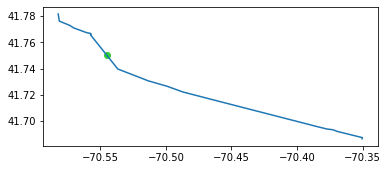

In [90]:
ax = MA_nearest_df.iloc[0:1].plot(color='limegreen')
MA_lines.iloc[15:16].plot(ax=ax)

So it looks like we'll have to get the index of the closest line (the actual index, not the value of the column 'index', which is confusing, sorry), and work with that.

I added the code to the for loop above. So here's our dataframe:

In [91]:
new_dataframe

,OBJECTID,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,state,geometry
15,6752,148335,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, EIA 861, https://www.iso-ne.com...",2015-09-21T00:00:00,IMAGERY,2018-05-01T00:00:00,NSTAR ELECTRIC COMPANY,345.0,345,N,UNKNOWN133456,TAP135423,31097.270720,MA,"LINESTRING (-70.35032 41.68586, -70.35044 41.6..."
15,6752,148335,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, EIA 861, https://www.iso-ne.com...",2015-09-21T00:00:00,IMAGERY,2018-05-01T00:00:00,NSTAR ELECTRIC COMPANY,345.0,345,N,UNKNOWN133456,TAP135423,31097.270720,MA,"LINESTRING (-70.35032 41.68586, -70.35044 41.6..."
15,6752,148335,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, EIA 861, https://www.iso-ne.com...",2015-09-21T00:00:00,IMAGERY,2018-05-01T00:00:00,NSTAR ELECTRIC COMPANY,345.0,345,N,UNKNOWN133456,TAP135423,31097.270720,MA,"LINESTRING (-70.35032 41.68586, -70.35044 41.6..."
15,6752,148335,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, EIA 861, https://www.iso-ne.com...",2015-09-21T00:00:00,IMAGERY,2018-05-01T00:00:00,NSTAR ELECTRIC COMPANY,345.0,345,N,UNKNOWN133456,TAP135423,31097.270720,MA,"LINESTRING (-70.35032 41.68586, -70.35044 41.6..."
15,6752,148335,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, EIA 861, https://www.iso-ne.com...",2015-09-21T00:00:00,IMAGERY,2018-05-01T00:00:00,NSTAR ELECTRIC COMPANY,345.0,345,N,UNKNOWN133456,TAP135423,31097.270720,MA,"LINESTRING (-70.35032 41.68586, -70.35044 41.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,53722,136092,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.vtep.org/do...",2015-09-21T00:00:00,IMAGERY,2015-10-01T00:00:00,NOT AVAILABLE,345.0,345,Y,FALL RIVER (345 KV),BERRY STREET,55021.263410,MA,"LINESTRING (-71.33536 42.01997, -71.33482 42.0..."
36,25914,106631,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.nyiso.com/p...",2015-09-21T00:00:00,IMAGERY,2016-02-12T00:00:00,NOT AVAILABLE,345.0,345,N,TAP136074,BERKSHIRE,50961.227237,MA,"LINESTRING (-73.09361 42.46868, -73.09409 42.4..."
15,6752,148335,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, EIA 861, https://www.iso-ne.com...",2015-09-21T00:00:00,IMAGERY,2018-05-01T00:00:00,NSTAR ELECTRIC COMPANY,345.0,345,N,UNKNOWN133456,TAP135423,31097.270720,MA,"LINESTRING (-70.35032 41.68586, -70.35044 41.6..."
36,25914,106631,"AC, OVERHEAD",IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.nyiso.com/p...",2015-09-21T00:00:00,IMAGERY,2016-02-12T00:00:00,NOT AVAILABLE,345.0,345,N,TAP136074,BERKSHIRE,50961.227237,MA,"LINESTRING (-73.09361 42.46868, -73.09409 42.4..."


In [92]:
new_dataframe.shape

(90, 19)

In [93]:
existing_MA.shape

(90, 27)

In [94]:
existing_MA_updated = pd.concat([existing_MA,
                         new_dataframe[['OBJECTID','TYPE','VOLTAGE','VOLT_CLASS','SHAPE__Len']].reset_index()],
                        axis=1)
existing_MA_updated

,index,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,turbine_class,geometry,index,OBJECTID,TYPE,VOLTAGE,VOLT_CLASS,SHAPE__Len
0,198,3046262.0,25-025115,2013-WTE-5497-OE,26723.0,MA,Barnstable County,25001,6th Space Warning Squadron,2013.0,2.0,3.36,GE Wind,GE1.68-82.5,1680.0,80.0,82.5,5345.62,121.3,3.0,3.0,None,Digital Globe,-70.541801,41.752491,0,POINT (-70.54180 41.75249),15,6752,"AC, OVERHEAD",345.0,345,31097.270720
1,199,3046335.0,25-025116,2013-WTE-5773-OE,26722.0,MA,Barnstable County,25001,6th Space Warning Squadron,2013.0,2.0,3.36,GE Wind,GE1.68-82.5,1680.0,80.0,82.5,5345.62,121.3,3.0,3.0,None,Digital Globe,-70.545303,41.754192,0,POINT (-70.54530 41.75419),15,6752,"AC, OVERHEAD",345.0,345,31097.270720
2,200,3039277.0,25-022039,2011-WTE-7516-OE,26676.0,MA,Barnstable County,25001,AFCEE MMR Turbines,2011.0,2.0,3.00,GE Wind,GE1.5-77,1500.0,80.0,77.0,4656.63,118.6,3.0,3.0,None,Digital Globe,-70.545303,41.757591,0,POINT (-70.54530 41.75759),15,6752,"AC, OVERHEAD",345.0,345,31097.270720
3,201,3039278.0,25-022038,2011-WTE-7517-OE,26677.0,MA,Barnstable County,25001,AFCEE MMR Turbines,2011.0,2.0,3.00,GE Wind,GE1.5-77,1500.0,80.0,77.0,4656.63,118.6,3.0,3.0,None,Digital Globe,-70.547798,41.759590,0,POINT (-70.54780 41.75959),15,6752,"AC, OVERHEAD",345.0,345,31097.270720
4,405,3034436.0,25-020032,2010-WTE-15019-OE,26672.0,MA,Barnstable County,25001,Air Force (Barnstable),2009.0,1.0,1.50,Fuhrlander,FL1500,1500.0,80.0,77.0,4656.63,118.6,3.0,3.0,2012-01-01,NAIP,-70.591103,41.657692,0,POINT (-70.59110 41.65769),15,6752,"AC, OVERHEAD",345.0,345,31097.270720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,52980,3042077.0,25-022236,2012-WTE-2583-OE,26669.0,MA,Bristol County,25005,University of Massachussetts Dartmouth,2012.0,1.0,0.60,Turbowinds,T-600-48,600.0,50.0,48.0,1809.56,74.1,3.0,3.0,2012-01-01,NAIP,-71.010597,41.626690,2,POINT (-71.01060 41.62669),78,53722,"AC, OVERHEAD",345.0,345,55021.263410
86,55513,3026616.0,25-020024,2008-ANE-443-OE,26683.0,MA,Berkshire County,25003,Williams Stone,2009.0,1.0,0.60,RRB,PS-600,600.0,65.0,47.0,1734.94,88.4,3.0,3.0,2012-01-01,NAIP,-73.069901,42.234192,2,POINT (-73.06990 42.23419),36,25914,"AC, OVERHEAD",345.0,345,50961.227237
87,56271,3008244.0,missing,missing,26720.0,MA,Barnstable County,25001,Woods Hole Research Center,2009.0,1.0,0.10,Northern Power Systems,NW100,100.0,37.0,21.0,346.36,47.5,2.0,3.0,2017-04-30,Digital Globe,-70.643204,41.548992,2,POINT (-70.64320 41.54899),15,6752,"AC, OVERHEAD",345.0,345,31097.270720
88,56769,3092344.0,25-062961,2018-WTE-7276-OE,-9999.0,MA,Berkshire County,25003,unknown Berkshire County,2019.0,2.0,-9999.00,missing,missing,-9999.0,-9999.0,-9999.0,-9999.00,-9999.0,1.0,1.0,2018-05-26,Digital Globe,-73.272507,42.596329,1,POINT (-73.27251 42.59633),36,25914,"AC, OVERHEAD",345.0,345,50961.227237


# That was ridiculous. :)